In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    from sklearn.datasets.samples_generator import make_blobs
except:
    from sklearn.datasets import make_blobs

%matplotlib inline

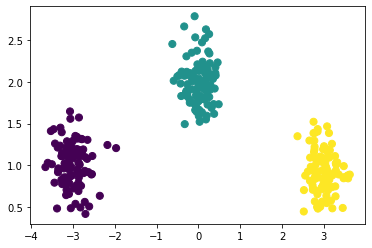

In [2]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

# One VS All

In [3]:
# Q11
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        @param estimator : binary base classifier used
        @param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        @param X: array-like, shape = [n_samples,n_features], input data
        @param y: array-like, shape = [n_samples,] class labels
        @return returns self
        """
        #Your code goes here
        # for each selected class, convert selected y labels into 1 and -1 for others
        # then, fit X with y_values
        for i in range(self.n_classes):
            y_converted = np.where(y==i,1,-1)
            self.estimators[i].fit(X, y_converted)        
              
        self.fitted = True  
        return self   

    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features] input data
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        #Replace the following return statement with your code
        
        #initialize score as all zeros
        score=np.zeros([self.n_classes,X.shape[0]])
        
        # for each rows, update score by using decision_function method
        for i in range(self.n_classes):
            score[i]=self.estimators[i].decision_function(X)
        
        # as we are returning shape = [n_samples, n_classes], retun transposed score
        return score.T                
    
    
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples,n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        #Replace the following return statement with your code
        
        # calling score results
        score = self.decision_function(X)
        
        # initialize y_pred as zeros
        y_pred = np.zeros([score.shape[0]])
        
        # now iterate for each row and update class that has the max score
        for i in range(len(y_pred)):
            y_pred[i] = np.where(score[i] == max(score[i]))[0][0]
        
        return y_pred 

/Users/yoontaepark/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Coeffs 0
[[-1.05853281 -0.90296639]]
Coeffs 1
[[ 0.2596985  -0.08742631]]
Coeffs 2
[[ 0.89161474 -0.82601573]]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

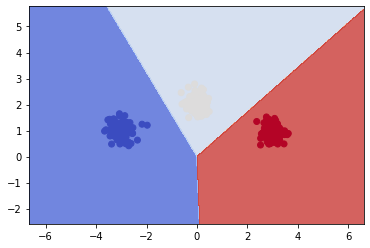

In [18]:
#Q12 Here we test the OneVsAllClassifier
from sklearn import svm
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X,y)

for i in range(3) :
    print("Coeffs %d"%i)
    print(clf_onevsall.estimators[i].coef_) #Will fail if you haven't implemented fit yet

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)


from sklearn import metrics
metrics.confusion_matrix(y, clf_onevsall.predict(X))

# Multiclass SVM

In [5]:
# Q13
def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)

def featureMap(X,y,num_classes) :
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], the class sensitive features for class y
    '''
    #The following line handles X being a 1d-array or a 2d-array
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    #your code goes here, and replaces following return
    
    # defining n_outFeatures as class * features, and initialize feature map
    n_outFeatures = num_classes * num_inFeatures
    feature_map = np.zeros([num_samples, n_outFeatures])
    
    # reshaping for 1d-array case
    if num_samples == 1:
        X = X.reshape((1,-1))
        
    # update feature map, so for selected target class columns, update x values
    for i, X_i in enumerate(X):
        feature_map[i, (y*num_inFeatures) : (y*num_inFeatures)+num_inFeatures] = X_i
        
    return feature_map

# Q14
def sgd(X, y, num_outFeatures, subgd, eta = 0.1, T = 10000):
    '''
    Runs subgradient descent, and outputs resulting parameter vector.
    @param X: array-like, shape = [n_samples,n_features], input training data 
    @param y: array-like, shape = [n_samples,], class labels
    @param num_outFeatures: number of class-sensitive features
    @param subgd: function taking x,y,w and giving subgradient of objective
    @param eta: learning rate for SGD
    @param T: maximum number of iterations
    @return: vector of weights
    '''
    num_samples = X.shape[0]
    #your code goes here and replaces following return statement

    # initialize w vector 
    w_vect = np.zeros(num_outFeatures)
    
    # iterate T times. For each iteration, shuffle index and update w_vect by using subgd param
    for _ in range(T):
        idx = np.random.randint(num_samples)
        w_vect = w_vect - eta*subgd(X[idx],y[idx],w_vect)
  
    return w_vect    
    

# Q15    
class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''
    Implements a Multiclass SVM estimator.
    '''
    def __init__(self, num_outFeatures, lam=1.0, num_classes=3, Delta=zeroOne, Psi=featureMap):       
        '''
        Creates a MulticlassSVM estimator.
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.num_outFeatures = num_outFeatures
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X,y : Psi(X,y,num_classes)
        self.fitted = False
    
    def subgradient(self,x,y,w):
        '''
        Computes the subgradient at a given data point x,y
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given x,y,w
        '''
        #Your code goes here and replaces the following return statement

        # initialze y_hat as 0, and get the result based on y_hat
        y_hat = 0
        res_tmp = self.Delta(y, y_hat) + np.dot(w, (self.Psi(x,y_hat)-self.Psi(x,y)).T)
        
        # iterate for given classes, and for each classes, get the result
        # compare and update if result for given class is larger
        for y_i in range(self.num_classes):
            res_y_i = self.Delta(y, y_i) + np.dot(w, (self.Psi(x,y_i)-self.Psi(x,y)).T)
            if res_tmp < res_y_i:
                res_tmp = res_y_i
                y_hat = y_i
        
        # retrun subgradient vector at given x,y,w
        return (2*self.lam*w + self.Psi(x,y_hat) - self.Psi(x,y))

        
    def fit(self,X,y,eta=0.1,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        self.coef_ = sgd(X,y,self.num_outFeatures,self.subgradient,eta,T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score on each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        #Your code goes here and replaces following return statement
        # initialize score
        score = np.zeros((X.shape[0], self.num_classes))
        
        # update score
        for i in range(X.shape[0]):
            for j in range(self.num_classes): # j values are y classes 
                score[i][j] = np.dot(self.coef_, self.Psi(X[i], j).T)        
        
        # return score
        return score        
            
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''

        #Your code goes here and replaces following return statement
        # recall score by using pre-defined decision function
        score = self.decision_function(X)
        
        y_pred = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y_pred[i] = np.where(score[i] == max(score[i]))[0][0]
        
        return y_pred
        

w:
[[-0.32248241 -0.02890479 -0.00091071  0.1444795   0.32339312 -0.1155747 ]]


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

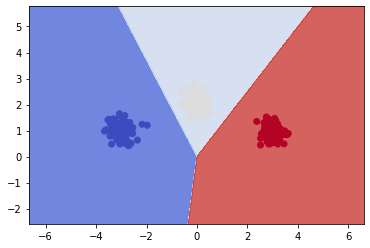

In [11]:
#Q16 the following code tests the MulticlassSVM and sgd
#will fail if MulticlassSVM is not implemented yet
est = MulticlassSVM(6,lam=1)
est.fit(X,y,eta=0.1)
print("w:")
print(est.coef_)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

from sklearn import metrics
metrics.confusion_matrix(y, est.predict(X))